In [1]:
#from transformer import Transformer 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import os
import gc
import random
import numpy as np
#import polars as pl
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import fastai
from fastai.vision.all import *

import math
import copy

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = "cpu"


max_seq_len = 206 + 2  # +2 is added to cover start and end token of sequence This will change to 457 in private set  # Set the maximum sequence length to 100
data_preprocessing_done = 0
save_pkl = 0
load_pkl = 0
small_dataset = 1

#Training Data
if small_dataset == 1:
    
    #Uncomment this section when uploading the jupyter notebook
    '''
    df_read = pd.read_csv('/media/spartans/COMMON:/RNA_Project/train_data.csv')
    
    criteria_2A3 = (df_read['experiment_type'] == '2A3_MaP') & (df_read['SN_filter'] == 1)
    criteria_DMS = (df_read['experiment_type'] == 'DMS_MaP') & (df_read['SN_filter'] == 1)

    df_2A3_Filter1 = df_read[criteria_2A3]
    df_2A3_Filter1 = df_2A3_Filter1.head(4)

    df_DMS_Filter1 = df_read[criteria_DMS]
    df_DMS_Filter1 = df_DMS_Filter1.head(4)

   
    df = pd.concat([df_2A3_Filter1, df_DMS_Filter1], ignore_index=True)
    
    df.to_csv('2A3_DMS_With_Filter1_Train_Data.csv', index=False)
    #df_2A3_Filter1.to_csv('2A3_DMS_With_Filter1_Train_Data.csv', index=False)
    '''
    df = pd.read_csv('2A3_DMS_With_Filter1_Train_Data.csv')
    #df = pd.read_csv('DMS_Data.csv')
    #df = pd.read_csv('2A3_Data.csv')
else:
    df = pd.read_csv('/media/spartans/COMMON:/RNA_Project/train_data.csv')
    



seed=69
os.environ['CUDA_LAUNCH_BLOCKING'] = str(1)

os.environ['TORCH_USE_CUDA_DSA'] = str(1)


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed)

In [2]:



#criteria_2A3 = (df_read['experiment_type'] == '2A3_MaP') & (df_read['SN_filter'] == '1')
#criteria_DMS = (df_read['experiment_type'] == 'DMS_MaP') & (df_read['SN_filter'] == '1')

#criteria_2A3 = ((df_read['experiment_type'] == 'DMS_MaP')  & df_read['SN_filter'] == 1 )
#df_2A3_Filter1 = df_read[criteria_2A3]
#df_2A3_Filter1
df

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCACAGCGCUGGGUUCGCCCAGCGCAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGGGUCCUCCUUCGGGAGGACCAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCCAGGUAUUGACUUCGGUCAAUACAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGCAUGCGGCUUCGGCCGCAUGAAAAGAAACAACAACAACAAC,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGGGUCCUCCUUCGGGAGGACCAAAAGAAACAACAACAACAAC,DMS_MaP,15k_DMS,1964,1.848,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCCAGGUAUUGACUUCGGUCAAUACAAAAGAAACAACAACAACAAC,DMS_MaP,15k_DMS,45863,9.291,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCAUGCAUGCGGCUUCGGCCGCAUGAAAAGAAACAACAACAACAAC,DMS_MaP,15k_DMS,6219,3.210,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,aa948762535f,GGGAACGACUCGAGUAGAGUCGAAAAACGCUGAUAUGGAUUUACUCCGAGGAGACGAACUACCACGAACAGGGGAAACUCUACCCGUGGCGUCUCCGUUUGACGAGUAAGUCCUAAGUCAACAUGCCAGGGUGUCACUUCGGUGACACCAAAAGAAACAACAACAACAAC,DMS_MaP,15k_DMS,7024,3.109,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        #print(output)
        return output

In [4]:
class PositionWiseFeedForward1(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
class PositionWiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        #print(f"x after first linear layer: {x.size()}")
        x = self.relu(x)
        #print(f"x after activation: {x.size()}")
        x = self.dropout(x)
        #print(f"x after dropout: {x.size()}")
        x = self.linear2(x)
        #print(f"x after 2nd linear layer: {x.size()}")
        return x


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        #print(x.size())
        #print(self.pe[:, :x.size(1)].size())
        #print((x + self.pe[:, :x.size(1)]).size())
        return x + self.pe[:, :x.size(1)]
    

class PositionalEncoding1(nn.Module):

    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self, x):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        print("PE size", PE.size())
        print("x size", x.size())
        print("PE x size", PE[:, :x.size(1)].size())
        print("stacked dim", stacked.size())
        return x + PE[:, :x.size(1)]
    

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x
    
    


In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        #print("forward ",src, src.size())
        #print("forward ", tgt, tgt.size())
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        print("Src_embedded size", src_embedded.size())
        print("tgt size ", tgt.size())
        print("TGT  = ", tgt)
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        print("tgt_embedded size", tgt_embedded.size())

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        #include here FC layers with output dimension = input dimension of the sequence (considering padding this will be const number)
        return output

In [9]:
#transformer




In [10]:
#src_data
#src_data.size()

In [11]:
#src_data.size()
#src_data = torch.randint(1, src_vocab_size, (64, max_seq_length)).to(device)  # (batch_size, seq_length)

In [12]:
#df


In [13]:
#where reactivity is NaN,
# have Nan replaced with average of all numbers in the sequence.

#Map sequence letters to numbers.

#Looking at Reads and Signal To Noise ..they appear to be somewhat coorelated.

#Create Dataset function


#In contrastive loss model... you can train based on#
#in a sequence which part is 2D fold and which part is 3D fold
#See notebook https://www.kaggle.com/code/something4kag/ribonanza-3d-coords-prep
#if it can be helpful
# Also analyze and which position in the sequence the fold can occur and which fold ended up happening based on the data

#another method to formulate contrastive learning model is by deferentiating sequences with low SNR and hence reactivity value will not be with high confidence.



In [14]:

#In RNA, the most common base pairings you'll find are between the following nucleotide bases:

#Adenine (A) and Uracil (U): A forms base pairs with U. This is a fundamental pairing and is commonly seen in RNA molecules, particularly in single-stranded regions. It is important for the stability of stem-loop structures and is a key component of RNA secondary structure.

#Guanine (G) and Cytosine (C): G forms base pairs with C, just as it does in DNA. This pairing is less common in RNA secondary structure but is still important for certain RNA molecules. It may be more prevalent in the context of ribozymes and catalytic RNA.

#While A-U and G-C are the primary base pairings in RNA, it's essential to understand that RNA can also exhibit non-canonical or non-standard base pairings, especially in more complex RNA structures. These non-canonical pairings can involve different combinations of A, U, G, and C and are often seen in tertiary structures or specialized RNA molecules with specific functions.

#The prevalence of A-U and G-C base pairings in an RNA molecule can vary depending on its sequence and function. For instance, regions that need to form stable secondary structures often rely on A-U pairings, while regions involved in catalytic activities may include G-C pairs. RNA structures are diverse and can exhibit a wide range of base pairing interactions to achieve their biological functions.



#So a contrastive loss can be formed here where
#AU pair GC pair are strong positive - stable
#AG, UC are less stable
#UG, UA, CG pair are unstable so negative .
#
#In RNA, the stable base pairs among the four nucleotide bases (A, G, U, and C) follow the standard Watson-Crick base-pairing rules. Here are the stable base pairs among these bases:

#GC pairs are more stable than AU pair


#So you can tokenzie these pairs in the transformer model.

In [15]:
#Formulate Convolution NN or Dense Net which takes SNR, Reactivity error and feeds into the final layer of Transformer network
# As an example
#Lowest Reactivity Error and High SNR are  strong positives
# Lowest SNR are strong negative.





#sequence length range from 115 to 206 in train dataset.
#in final it will range from 207 to 457

In [16]:
#In positional encoding
#pos means the position of the word in the sequence.
#i means the index for that particular word vector (index of the dimension)
#dmodel is the dimension for e.g 512 from the example


#For 2 experiment types i.e. DMS and 2A3 you can have start and end  token in a sequence for which data is available.
#.e. start_DMS, end_DMS, start_2A3, end_2A3.




In [17]:
#df

In [18]:
#df.iloc[:,150:213]


In [19]:
if data_preprocessing_done == 0:
    #Assigning reactivity Columns to react_columns dataframe and replacing NaN with 0.000 

    #del(mean_reactivity)
    #del(react_columns_New)
    #del(react_columns)
    react_columns = df.iloc[:,7:213].fillna(0.000000)

    #Find mean of reactivity per row
    #df['mean'] = df.mean(axis=1)
    #react_columns = react_columns.applymap(lambda x: 0.0 if x < 0.0 else x)
    react_columns = react_columns.applymap(lambda x: 0 if isinstance(x, (float, int)) and x < 0 else x)

    react_columns_mean = react_columns.mean(axis=1)
    #Free up memory
    del(react_columns)

    #Now replace NaN in react_columns with mean_reactivity
    #react_columns_New = df.iloc[:,7:213].fillna(mean_reactivity)

/tmp/ipykernel_10063/398611985.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  react_columns = react_columns.applymap(lambda x: 0 if isinstance(x, (float, int)) and x < 0 else x)


In [20]:

if data_preprocessing_done == 0:
    react_columns = df.iloc[:,7:213] #You may have to capture those indices as per sequence length i.e. when it extends to 457

    # Replace NaN values in each row with values from replace_values array
    for index, row in tqdm(react_columns.iterrows(), total=len(react_columns), desc="Processing rows"):
        react_columns.loc[index] = row.fillna(react_columns_mean[index])
    
    react_columns = react_columns.applymap(lambda x: 0 if isinstance(x, (float, int)) and x < 0 else x)


        
        
        

Processing rows: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 5047.30it/s]
/tmp/ipykernel_10063/1102462686.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  react_columns = react_columns.applymap(lambda x: 0 if isinstance(x, (float, int)) and x < 0 else x)


In [21]:
#react_columns_New = df.iloc[:,7:213].fillna(react_columns['mean_reactivity'])
#react_columns_New
#react_columns.columns


#for column_name in tqdm(react_columns.columns, total=len(react_columns.columns), desc="Processing"):
#    df[column_name] = react_columns[column_name]
    
#react_columns['sequence'] = df['experiment_type'] + 'start' + df['sequence']
#react_columns['sequence'] = react_columns['sequence'] + 'end' + df['experiment_type']






In [22]:
seq_map = {'A':1,
           'C':2,
           'G':3,
           'U':4, 
           'M':5,  #Start token of DMS exp seq
           'N':6,  #End token of DMS exp seq
           'T':7,  #Start token of 2A3 exp seq
           'X':8,  #End token of 2A3 exp seq
           'Z':0   #Padding token
          }
#for s in df.at[0,'sequence']:
#    print(seq_map[s])
#df

#test_cell = [seq_map[s] for s in df.at[0, 'sequence']]
#print(test_cell)

#len(df.at[0, 'sequence'])
# Create a list of random data samples (for demonstration)
#max_seq_len = 206 #This will change to 457 in private set  # Set the maximum sequence length to 100


In [23]:
# Iterate over rows and replace a specific value in all columns

#seq = [self.seq_map[s] for s in seq]
#for index, row in df.iterrows():
# Create a list of random data samples (for demonstration)
#max_seq_len = 206 #This will change to 457 in private set  # Set the maximum sequence length to 100
if data_preprocessing_done == 0:
    df_sq = copy.deepcopy(df['sequence']) #saving a backup of sequences.
    #react_columns['maped_sequence'] = [' ']*len(react_columns)
    #for index, row in tqdm(df.iterrows(), total=len(df.rows), desc="Processing rows"):
    for index, row in tqdm(react_columns.iterrows(), total=len(react_columns), desc="Processing rows"):
        if df.at[index, 'experiment_type'] == "2A3_MaP":
            concat_seq = 'T' + df.at[index, 'sequence'] + 'X'
        if df.at[index, 'experiment_type'] == "DMS_MaP":
            concat_seq = 'M' + df.at[index, 'sequence'] + 'N'
        padding = "Z"*(max_seq_len - 2 - len(df.at[index, 'sequence']))
        concatenated_seq = concat_seq + padding
        df.at[index, 'sequence'] = [seq_map[s] for s in concatenated_seq]
        #react_columns.at[index, 'maped_sequence'] = [seq_map[s] for s in concatenated_seq]


Processing rows: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8522.84it/s]


In [24]:
#len(df.at[0, 'sequence'])
#df
#react_columns['maped_sequence'] = [' ']*len(react_columns)
#react_columns.to_pickle("react_columns.pkl")
if data_preprocessing_done == 0:
    react_columns['reactivity_0207'] = copy.deepcopy(react_columns['reactivity_0206'])
    react_columns['reactivity_0208'] = copy.deepcopy(react_columns['reactivity_0206'])
    react_columns['mapped_sequence'] = copy.deepcopy(df['sequence'])
    #del react_columns['reactivity_0207']
    #del react_columns['reactivity_0208']
if save_pkl == 1:
    react_columns.to_pickle("react_columns.pkl")

if load_pkl == 1:
    react_columns = pd.read_pickle("react_columns.pkl")
    


In [25]:
#react_columns.select_dtypes(exclude="NaN")
#df[~df['COLUMN1'].str.contains('TOTAL')]
#react_columns.iloc[~react_columns[:,1].str.contains('NaN')]

#react_columns.iloc[:,1]

#data1 = [[1, 1, 2], [6, 4, 2], [4, 2, 1], [4, 2, 3]]

#daf = pd.DataFrame(data1)
#print(data1)
#print(daf.mean())
#react_columns['sequence'][150:170][160]
react_columns

,reactivity_0001,reactivity_0002,reactivity_0003,reactivity_0004,reactivity_0005,reactivity_0006,reactivity_0007,reactivity_0008,reactivity_0009,reactivity_0010,...,reactivity_0200,reactivity_0201,reactivity_0202,reactivity_0203,reactivity_0204,reactivity_0205,reactivity_0206,reactivity_0207,reactivity_0208,mapped_sequence
0,0.104340,0.104340,0.104340,0.104340,0.104340,0.104340,0.104340,0.104340,0.104340,0.104340,...,0.104340,0.104340,0.104340,0.104340,0.104340,0.104340,0.104340,0.104340,0.104340,"[7, 3, 3, 3, 1, 1, 2, 3, 1, 2, 4, 2, 3, 1, 3, 4, 1, 3, 1, 3, 4, 2, 3, 1, 1, 1, 1, 1, 2, 1, 4, 4, 3, 1, 4, 1, 4, 3, 3, 1, 4, 4, 4, 1, 2, 4, 2, 2, 3, 1, 3, 3, 1, 3, 1, 2, 3, 1, 1, 2, 4, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 1, 2, 4, 2, 4, 1, 2, 2, 2, 3, 4, 3, 3, 2, 3, 4, 2, 4, 2, 2, 3, 4, 4, ...]"
1,0.106801,0.106801,0.106801,0.106801,0.106801,0.106801,0.106801,0.106801,0.106801,0.106801,...,0.106801,0.106801,0.106801,0.106801,0.106801,0.106801,0.106801,0.106801,0.106801,"[7, 3, 3, 3, 1, 1, 2, 3, 1, 2, 4, 2, 3, 1, 3, 4, 1, 3, 1, 3, 4, 2, 3, 1, 1, 1, 1, 1, 2, 2, 4, 4, 3, 1, 4, 1, 4, 3, 3, 1, 4, 4, 4, 1, 2, 4, 2, 2, 3, 1, 3, 3, 1, 3, 1, 2, 3, 1, 1, 2, 4, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 1, 2, 4, 2, 4, 1, 2, 2, 2, 3, 4, 3, 3, 2, 3, 4, 2, 4, 2, 2, 3, 4, 4, ...]"
2,0.098947,0.098947,0.098947,0.098947,0.098947,0.098947,0.098947,0.098947,0.098947,0.098947,...,0.098947,0.098947,0.098947,0.098947,0.098947,0.098947,0.098947,0.098947,0.098947,"[7, 3, 3, 3, 1, 1, 2, 3, 1, 2, 4, 2, 3, 1, 3, 4, 1, 3, 1, 3, 4, 2, 3, 1, 1, 1, 1, 1, 2, 4, 4, 4, 3, 1, 4, 1, 4, 3, 3, 1, 4, 4, 4, 1, 2, 4, 2, 2, 3, 1, 3, 3, 1, 3, 1, 2, 3, 1, 1, 2, 4, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 1, 2, 4, 2, 4, 1, 2, 2, 2, 3, 4, 3, 3, 2, 3, 4, 2, 4, 2, 2, 3, 4, 4, ...]"
3,0.105214,0.105214,0.105214,0.105214,0.105214,0.105214,0.105214,0.105214,0.105214,0.105214,...,0.105214,0.105214,0.105214,0.105214,0.105214,0.105214,0.105214,0.105214,0.105214,"[7, 3, 3, 3, 1, 1, 2, 3, 1, 2, 4, 2, 3, 1, 3, 4, 1, 3, 1, 3, 4, 2, 3, 1, 1, 1, 1, 1, 2, 3, 1, 4, 3, 1, 4, 1, 4, 3, 3, 1, 4, 4, 4, 1, 2, 4, 2, 2, 3, 1, 3, 3, 1, 3, 1, 2, 3, 1, 1, 2, 4, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 1, 2, 4, 2, 4, 1, 2, 2, 2, 3, 4, 3, 3, 2, 3, 4, 2, 4, 2, 2, 3, 4, 4, ...]"
4,0.281481,0.281481,0.281481,0.281481,0.281481,0.281481,0.281481,0.281481,0.281481,0.281481,...,0.281481,0.281481,0.281481,0.281481,0.281481,0.281481,0.281481,0.281481,0.281481,"[5, 3, 3, 3, 1, 1, 2, 3, 1, 2, 4, 2, 3, 1, 3, 4, 1, 3, 1, 3, 4, 2, 3, 1, 1, 1, 1, 1, 2, 2, 4, 4, 3, 1, 4, 1, 4, 3, 3, 1, 4, 4, 4, 1, 2, 4, 2, 2, 3, 1, 3, 3, 1, 3, 1, 2, 3, 1, 1, 2, 4, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 1, 2, 4, 2, 4, 1, 2, 2, 2, 3, 4, 3, 3, 2, 3, 4, 2, 4, 2, 2, 3, 4, 4, ...]"
5,0.228019,0.228019,0.228019,0.228019,0.228019,0.228019,0.228019,0.228019,0.228019,0.228019,...,0.228019,0.228019,0.228019,0.228019,0.228019,0.228019,0.228019,0.228019,0.228019,"[5, 3, 3, 3, 1, 1, 2, 3, 1, 2, 4, 2, 3, 1, 3, 4, 1, 3, 1, 3, 4, 2, 3, 1, 1, 1, 1, 1, 2, 4, 4, 4, 3, 1, 4, 1, 4, 3, 3, 1, 4, 4, 4, 1, 2, 4, 2, 2, 3, 1, 3, 3, 1, 3, 1, 2, 3, 1, 1, 2, 4, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 1, 2, 4, 2, 4, 1, 2, 2, 2, 3, 4, 3, 3, 2, 3, 4, 2, 4, 2, 2, 3, 4, 4, ...]"
6,0.244432,0.244432,0.244432,0.244432,0.244432,0.244432,0.244432,0.244432,0.244432,0.244432,...,0.244432,0.244432,0.244432,0.244432,0.244432,0.244432,0.244432,0.244432,0.244432,"[5, 3, 3, 3, 1, 1, 2, 3, 1, 2, 4, 2, 3, 1, 3, 4, 1, 3, 1, 3, 4, 2, 3, 1, 1, 1, 1, 1, 2, 3, 1, 4, 3, 1, 4, 1, 4, 3, 3, 1, 4, 4, 4, 1, 2, 4, 2, 2, 3, 1, 3, 3, 1, 3, 1, 2, 3, 1, 1, 2, 4, 1, 2, 2, 1, 2, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 1, 2, 4, 2, 4, 1, 2, 2, 2, 3, 4, 3, 3, 2, 3, 4, 2, 4, 2, 2, 3, 4, 4, ...]"
7,0.245485,0.245485,0.245485,0.245485,0.245485,0.245485,0.245485,0.245485,0.245485,0.245485,...,0.245485,0.245485,0.245485,0.245485,0.245485,0.245485,0.245485,0.245485,0.245485,"[5, 3, 3, 3, 1, 1, 2, 3, 1, 2, 4, 2, 3, 1, 3, 4, 1, 3, 1, 3, 4, 2, 3, 1, 1, 1, 1, 1, 2, 3, 2, 4, 3, 1,

In [26]:
# Define a custom dataset class for your data
class CustomDataset(Dataset):
    def __init__(self, data, max_seq_len):
        self.data = data
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #src_sequence, trg_sequence = [0,1] #self.data[idx]
        #src_sequence = self.data['reactivity_0001']
        #trg_sequence = self.data['mapped_sequence']
        #list_src_trg_seq = self.data.loc[idx].apply(lambda row: row.tolist(), axis=1)
        #merged_values = ','.join(map(str, df.loc[row_index_to_merge][:-1]))
        #list_src_trg_seq = ','.join(map(str, self.data.loc[row_index_to_merge][:-1]))
        #src_sequence = list_src_trg_seq[0:-1]
        #srg_sequence = list_src_trg_seq[-1]
        
        #trg_sequence = ','.join(map(str, self.data.loc[idx][:-1]))
        #src_sequence = [','.join(map(str, self.data.loc[idx][-1]))]
        
        trg_sequence = torch.tensor(self.data.iloc[idx, :].tolist()[:-1])
        src_sequence = torch.tensor(self.data.iloc[idx, :].tolist()[-1])
        
        #print("Size src seq ", src_sequence.size())
        #print("Size trg seq ", trg_sequence.size())
        

        #trg_sequence = self.data.iloc[idx, :].totensor()[:-1]
        #src_sequence = self.data.iloc[idx, :].totensor()[-1]
        
        # Pad sequences with zeros to match the length of the longest sequence in each batch
        #max_len = max(len(src_sequence), len(trg_sequence), self.max_seq_len)
        #src_sequence += [0] * (max_len - len(src_sequence))
        #trg_sequence += [0] * (max_len - len(trg_sequence))
        #print("Index ", idx, " SRC--", src_sequence, " TRG--", trg_sequence)
        #print("SRC LEN ", len(src_sequence), " TRG LEN ", len(trg_sequence))
        return src_sequence, trg_sequence



#data = []
#for _ in range(5):
#    src_sequence = [random.randint(1, 100) for _ in range(random.randint(5, max_seq_len))]
#    trg_sequence = [random.randint(1, 100) for _ in range(random.randint(5, max_seq_len))]
#    data.append((src_sequence, trg_sequence))

#print("src", len(src_sequence))
#print("trg", len(trg_sequence))

#list_src_trg_seq = react_columns.apply(lambda row: row.tolist(), axis=1)

    
# Create a DataLoader for batching and shuffling
batch_size = 1
#batch_size = 3


# Define the size of the training set
dataset_size = len(react_columns)
train_size = int(0.9 * dataset_size)
test_size = dataset_size - train_size

# Create indices for training and testing sets
#indices = list(range(dataset_size))
#train_indices, test_indices = random_split(indices, [train_size, test_size])
#print(train_indices)
#print(test_indices)
custom_dataset = CustomDataset(react_columns, max_seq_len)
train_indices, test_indices = random_split(custom_dataset, [train_size, test_size])
train_dataloader = DataLoader(train_indices, batch_size=batch_size)
test_dataloader = DataLoader(test_indices, batch_size=batch_size)

#train_dataloader = DataLoader(custom_dataset, batch_size=batch_size)
#test_dataloader = DataLoader(custom_dataset, batch_size=batch_size)


#data = DataLoader(custom_dataset)
  
# Example usage in the training loop (as previously shown)
#for batch in dataloader:
#    print("Inside DataLoader Func")
#    src, trg = batch
#    print("SRC -", src, src.size())
#    print("TRG -", trg, trg.size())
    # ...

    

In [27]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
#print(device)
src_vocab_size = 512
#tgt_vocab_size = 5000
tgt_vocab_size = 512
d_model = 256
num_heads = 8
num_layers = 6
d_ff = 1024
max_seq_length = max_seq_len
dropout = 0.1



src_vocab_size = 5000
#tgt_vocab_size = 5000
tgt_vocab_size = 206
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = max_seq_len
dropout = 0.1

# Generate random sample data
#src_data = torch.randint(1, src_vocab_size, (64, max_seq_length)).to(device)  # (batch_size, seq_length)
#tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length)).to(device)  # (batch_size, seq_length)

transformer_model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout).to(device)

#transformer = nn.Transformer()

In [28]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)


print(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9, weight_decay=0, amsgrad=False)


#transformer.train()
epochx_train =[]
epochx_test =[]
train_losses = []
val_losses = []

cpu


In [29]:
'''
def los_func(src_data, tgt_data, tgt_vocab_size):
    transformer_model.eval()
    output = transformer_model(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    transformer_model.train()
    return loss

for epoch in range(3):
    for src_data, tgt_data in train_dataloader:          
        src_data, tgt_data = src_data.to(device), tgt_data.to(device,  dtype=torch.long)
        learn = Learner(data, transformer_model, loss_func=los_func(src_data, tgt_data,tgt_vocab_size)).to_fp16() 
        learn.fit_one_cycle(32, lr_max=5e-4, wd=0.05, pct_start=0.02)
        torch.save(learn.model.state_dict(),"Model_Trained.model")
        gc.collect()
'''

'\ndef los_func(src_data, tgt_data, tgt_vocab_size):\n    transformer_model.eval()\n    output = transformer_model(src_data, tgt_data[:, :-1])\n    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))\n    transformer_model.train()\n    return loss\n\nfor epoch in range(3):\n    for src_data, tgt_data in train_dataloader:          \n        src_data, tgt_data = src_data.to(device), tgt_data.to(device,  dtype=torch.long)\n        learn = Learner(data, transformer_model, loss_func=los_func(src_data, tgt_data,tgt_vocab_size)).to_fp16() \n        learn.fit_one_cycle(32, lr_max=5e-4, wd=0.05, pct_start=0.02)\n        torch.save(learn.model.state_dict(),"Model_Trained.model")\n        gc.collect()\n'

TRG - tensor([[2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01,
         2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01,
         2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01,
         2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01, 2.4443e-01,
         2.4443e-01, 2.4443e-01, 1.4960e+00, 9.8200e-01, 1.4500e-01, 0.0000e+00,
         2.9300e-01, 7.3000e-02, 9.9000e-02, 5.9300e-01, 2.4200e-01, 4.7200e-01,
         0.0000e+00, 4.8500e-01, 0.0000e+00, 0.0000e+00, 7.3000e-02, 0.0000e+00,
         3.4000e-01, 0.0000e+00, 1.6900e-01, 0.0000e+00, 2.6600e-01, 1.3400e-01,
         5.0800e-01, 1.2400e-01, 1.2000e-02, 2.0600e-01, 8.5000e-02, 2.8000e-01,
         1.1000e-01, 0.0000e+00, 4.9500e-01, 6.6900e-01, 1.4500e-01, 1.4160e+00,
         4.6000e+00, 0.0000e+00, 0.0000e+00, 2.6600e-01, 5.7000e-01, 4.1200e-01,
         8.8500e-01, 1.0150e+00, 1.4640e+00, 1.5250e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0

Epoch: 1, Training Loss: 1.4470146894454956
Src_embedded size torch.Size([1, 208, 512])
tgt size  torch.Size([1, 207])
TGT  =  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tgt_embedded size torch.Size([1, 207, 512])
Epoch: 1, Validation Loss: 2.5952563285827637
TRG - tensor([[1.0434e-01, 1.0434e-01, 1.0434e-01, 1.0434e-01, 1.0434e-01, 1.04

Epoch: 1, Training Loss: 1.3292162418365479
Src_embedded size torch.Size([1, 208, 512])
tgt size  torch.Size([1, 207])
TGT  =  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tgt_embedded size torch.Size([1, 207, 512])
Epoch: 1, Validation Loss: 1.524221658706665
TRG - tensor([[0.1068, 0.1068, 0.1068, 0.1068, 0.1068, 0.1068, 0.1068, 0.1068, 0

Epoch: 2, Training Loss: 1.7482781410217285
Src_embedded size torch.Size([1, 208, 512])
tgt size  torch.Size([1, 207])
TGT  =  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tgt_embedded size torch.Size([1, 207, 512])
Epoch: 2, Validation Loss: 1.1308691501617432
TRG - tensor([[0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 

Epoch: 2, Training Loss: 1.5487492084503174
Src_embedded size torch.Size([1, 208, 512])
tgt size  torch.Size([1, 207])
TGT  =  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tgt_embedded size torch.Size([1, 207, 512])
Epoch: 2, Validation Loss: 0.9954688549041748
TRG - tensor([[9.8947e-02, 9.8947e-02, 9.8947e-02, 9.8947e-02, 9.8947e-02, 9.89

Epoch: 2, Training Loss: 0.6193047761917114
Src_embedded size torch.Size([1, 208, 512])
tgt size  torch.Size([1, 207])
TGT  =  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tgt_embedded size torch.Size([1, 207, 512])
Epoch: 2, Validation Loss: 1.3473241329193115
TRG - tensor([[0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 

Epoch: 3, Training Loss: 1.3905000686645508
Src_embedded size torch.Size([1, 208, 512])
tgt size  torch.Size([1, 207])
TGT  =  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tgt_embedded size torch.Size([1, 207, 512])
Epoch: 3, Validation Loss: 1.5518141984939575
TRG - tensor([[0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 0.2455, 

Epoch: 3, Training Loss: 0.7752211093902588
Src_embedded size torch.Size([1, 208, 512])
tgt size  torch.Size([1, 207])
TGT  =  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tgt_embedded size torch.Size([1, 207, 512])
Epoch: 3, Validation Loss: 1.2106611728668213
TRG - tensor([[9.8947e-02, 9.8947e-02, 9.8947e-02, 9.8947e-02, 9.8947e-02, 9.89

Epoch: 3, Training Loss: 0.6773747205734253
Src_embedded size torch.Size([1, 208, 512])
tgt size  torch.Size([1, 207])
TGT  =  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tgt_embedded size torch.Size([1, 207, 512])
Epoch: 3, Validation Loss: 1.0746290683746338
TRG - tensor([[0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 0.2815, 

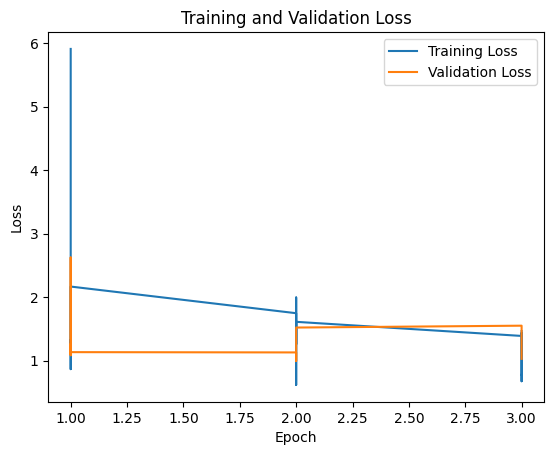

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer_model.train()
epochx_train =[]
epochx_test =[]
train_losses = []
val_losses = []
for epoch in range(3):
    for src_data, tgt_data in train_dataloader:
        #    print("Inside DataLoader Func")
        #src_data, trg_data = src_data.to(device), trg_data.to(device)
        #print("SRC -", src_data, src_data.size())
        print("TRG -", tgt_data, tgt_data.size())
        #src_data = torch.tensor(src_data)
        #trg_data = torch.tensor(trg_data)
        src_data, tgt_data = src_data.to(device), tgt_data.to(device,  dtype=torch.long)
        train_loss = 0
        val_loss = 0
        transformer_model.train()
        optimizer.zero_grad()
        #src_data = src_data.to(device)
        #x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        #y = y.to(device=device, dtype=torch.long)
        #tgt_data = tgt_data.to(device)
        #print("TRG DATA ", tgt_data.size())
        output = transformer_model(src_data, tgt_data[:, :-1])
        #output = transformer(src_data, tgt_data)
        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch+1}, Training Loss: {loss.item()}")
        train_loss += loss.item()
        train_losses.append(train_loss / len(src_data))
        epochx_train.append(epoch+1)
        #validation part
        #Restructure code with validation set data
        transformer_model.eval()
        with torch.no_grad():
            for src_data, tgt_data in test_dataloader:
                #This should be validation set data.
                src_data = src_data.to(device=device)
                tgt_data = tgt_data.to(device=device, dtype=torch.long)
                output = transformer_model(src_data, tgt_data[:, :-1])
                loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
                print(f"Epoch: {epoch+1}, Validation Loss: {loss.item()}")
                val_loss += loss.item()
                val_losses.append(val_loss / len(src_data))
                epochx_test.append(epoch+1)
        

torch.save(transformer_model, "Trained_Model.model")

#print(epochx_train, len(epochx_train))
#print(train_losses, len(train_losses))
# Plot both training and validation losses
#plt.bar(epochx_train, height=0)
plt.plot(epochx_train, train_losses, label='Training Loss')
plt.plot(epochx_test, val_losses,  label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()  

In [32]:
#Validation predict
#val_df = 

#Read TEST Sequence
test_df = pd.read_csv('/media/spartans/COMMON:/RNA_Project/test_sequences.csv')

In [40]:
test_df.head(4)
test_df.at[0, 'sequence']

'GGGAACGACUCGAGUAGAGUCGAAAAUUUCCUUCCAAAUCCUGAGGGAGAGAUAGAGGCGGAGGGUCUGGGGGAGGAAUUAAAACACAAGGUCUCCUCCCCUCUCGCCUGUCCGAACUUGGGGGCACCCCGGCUCGUACUUCGGUACGAGCCGGGGAAAAGAAACAACAACAACAAC'

In [36]:
len(test_df['sequence'][0])

177

In [ ]:
test_df['DMS_sequence'] = copy.deepcopy(test_df['sequence'])
test_df['2A3_sequence'] = copy.deepcopy(test_df['sequence'])


test_df_sq = copy.deepcopy(test_df['sequence']) #saving a backup of sequences.
#react_columns['maped_sequence'] = [' ']*len(react_columns)
#for index, row in tqdm(df.iterrows(), total=len(df.rows), desc="Processing rows"):
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing rows"):
    
    padding = "Z"*(max_seq_len - 2 - len(test_df.at[index, 'sequence']))
    form_DMS_seq = 'M' + test_df.at[index, 'sequence'] + 'N' + padding
    form_2A3_seq = 'T' + test_df.at[index, 'sequence'] + 'X' + padding
    

    test_df.at[index, 'DMS_sequence'] = [seq_map[s] for s in form_DMS_seq]
    test_df.at[index, '2A3_sequence'] = [seq_map[s] for s in form_2A3_seq]
    

Processing rows:  48%|███████████████████████████████████████████████████████████                                                                | 645957/1343823 [01:14<01:15, 9283.20it/s]

In [ ]:
#torch.no_grad():
#src_data = src_data.to(device=device)
#tgt_data = tgt_data.to(device=device, dtype=torch.long)
#output = transformer_model(src_data, tgt_data[:, :-1])